In [80]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import seaborn as sns
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as stats

In [2]:
## load data

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
## strip spaces from column names
life_df.columns = life_df.columns.str.strip()

In [5]:
life_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,...,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Albania,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,...,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,...,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,...,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,...,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,...,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000


***
# Data preperation
## Handling missing data

In [6]:
## percent of empty entries in each column
life_df.isnull().sum()/life_df.shape[0]*100

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

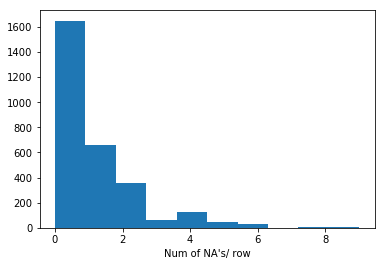

In [7]:
## Are there rows with multiple missing entries?
na_count = life_df.isnull().sum(axis=1)
plt.hist(na_count)
plt.xlabel("Num of NA's/ row")
plt.show()

In [8]:
## Eliminate rows with more than 3 na's

# save na's per column stats
size = life_df.shape[0]
before_drop = (life_df.isnull().sum()/size*100).values

# subset
life_df = life_df[na_count <= 2]
print('{} ({:.3}%) rows were dropped\n'.format(size-life_df.shape[0], (size-life_df.shape[0])/size*100))

# print percent of empty cells before and after dropping rows
after_drop = (life_df.isnull().sum()/size*100).values
drop_ind = life_df.columns
print('{0:<32}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(drop_ind, before_drop, after_drop):
    print('{0:<32}      {1:<15.3}      {2:<15.3}'.format(*row)) 

272 (9.26%) rows were dropped

                                      before            after       
Country                               0.0                  0.0            
Year                                  0.0                  0.0            
Status                                0.0                  0.0            
Life expectancy                       0.34                 0.0            
Adult Mortality                       0.34                 0.0            
infant deaths                         0.0                  0.0            
Alcohol                               6.6                  4.36           
percentage expenditure                0.0                  0.0            
Hepatitis B                           18.8                 15.3           
Measles                               0.0                  0.0            
BMI                                   1.16                 0.0            
under-five deaths                     0.0                  0.0            


In [9]:
# using pandas interpolation function to fill missing values
fill_cols = life_df.columns[life_df.isnull().sum() > 0]
countries = life_df['Country'].unique()

# save empty enteries stats
before_inter = (life_df.isnull().sum()/life_df.shape[0]*100).values

for country in countries:
    life_df.loc[life_df['Country'] == country, fill_cols] = life_df.loc[life_df['Country'] == country, fill_cols].interpolate(method='linear', limit_direction='both')

# print percent of empty cells before and after imputation
after_inter = (life_df.isnull().sum()/life_df.shape[0]*100).values
inter_ind = (life_df.isnull().sum()/life_df.shape[0]*100).index
print('{0:<32}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(inter_ind, before_inter, after_inter):
    print('{0:<32}      {1:<15.3}      {2:<15.3}'.format(*row))   

                                      before            after       
Country                               0.0                  0.0            
Year                                  0.0                  0.0            
Status                                0.0                  0.0            
Life expectancy                       0.0                  0.0            
Adult Mortality                       0.0                  0.0            
infant deaths                         0.0                  0.0            
Alcohol                               4.8                  0.0            
percentage expenditure                0.0                  0.0            
Hepatitis B                           16.9                 4.54           
Measles                               0.0                  0.0            
BMI                                   0.0                  0.0            
under-five deaths                     0.0                  0.0            
Polio                          

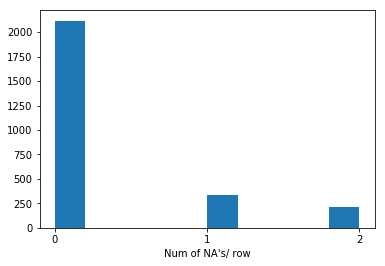

In [10]:
## Are there still rows with multiple missing entries?
na_count = life_df.isnull().sum(axis=1)
plt.hist(na_count)
plt.xlabel("Num of NA's/ row")
plt.xticks(np.arange(0, 3, 1))
plt.show()

In [11]:
# Use linear regression to fill missing values

# save empty enteries stats
nrow_before = life_df.shape[0]
before_impute = (life_df.isnull().sum()/nrow_before*100).values

# for each target column with missing values, select columns with more than 0.5 absloute correlation
target_cols = life_df.columns[(life_df.isnull().sum()/life_df.shape[0]*100) > 0]

# intitalize LinearRegression function
linreg = LinearRegression()

# generate correlation matrix
corr = life_df.corr()

for target_col in target_cols:
    cols_of_interest = corr.index[abs(corr[target_col]) > 0.5]

    # use linear regression to impute missing data in columns of interest
    data = life_df[cols_of_interest].copy()
    # drop rows with na's beside na rows in target col. Then, drop any columns with remaining na's
    for index, row in data.iterrows():
        if np.isnan(row[target_col]):
            data.drop(index=index, axis=1, inplace=True)
        elif np.isnan(row).sum() > 0:
            data.drop(index, inplace=True)
            
    
    # subset data to proper format for testing and training
    x_train = data[ data[target_col].notnull()].drop(columns=target_col)
    y_train = data[ data[target_col].notnull()][target_col]
    x_test = data[ data[target_col].isnull()].drop(columns=target_col)
    
    # train
    linreg.fit(x_train, y_train)
    
    #predict
    try:
        pred = linreg.predict(x_test)
        # fill missing values based on prediction
        life_df[target_col][life_df[target_col].isnull()] = pred
    except:
        print('Insufficient data for prediction. Rows with missing data will be eliminated')
        life_df = life_df[life_df.index.isin(data.index.tolist())]

# print percent of empty entries before and after imputation
nrow_after = life_df.shape[0]
after_impute = (life_df.isnull().sum()/nrow_after*100).values
impute_ind = (life_df.isnull().sum()/nrow_after*100).index
print('{0:<32}      {1:<12}{2}      {3:<12}{4}'.format('', 'before', nrow_before, 'after', nrow_after)) 
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<32}      {1:<15.3}      {2:<15.3}'.format(*row)) 

Insufficient data for prediction. Rows with missing data will be eliminated
Insufficient data for prediction. Rows with missing data will be eliminated
Insufficient data for prediction. Rows with missing data will be eliminated
                                      before      2666      after       2117
Country                               0.0                  0.0            
Year                                  0.0                  0.0            
Status                                0.0                  0.0            
Life expectancy                       0.0                  0.0            
Adult Mortality                       0.0                  0.0            
infant deaths                         0.0                  0.0            
Alcohol                               0.0                  0.0            
percentage expenditure                0.0                  0.0            
Hepatitis B                           4.54                 0.0            
Measles             

In [12]:
life_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2117,2117.000000,2117,2117.000000,2117.000000,2117.000000,2117.000000,2117.000000,2117.000000,2117.000000,...,2117.000000,2117.000000,2117.000000,2117.000000,2117.000000,2.117000e+03,2117.000000,2117.000000,2117.000000,2117.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Guatemala,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.510156,NaN,68.139254,174.173831,36.076523,4.369051,642.698821,74.460085,2671.142655,...,80.609825,5.898111,80.720359,2.184034,5424.655707,1.345302e+07,5.108503,5.178507,0.609011,11.724610
std,NaN,4.600538,NaN,9.626245,129.989101,136.556755,3.997932,1714.794301,28.647224,11941.642546,...,24.167849,2.305415,24.212907,5.840598,11401.233398,6.331574e+07,4.715725,4.809639,0.201656,3.156191
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,62.000000,75.000000,1.000000,0.610000,20.218228,64.000000,0.000000,...,75.000000,4.360000,76.000000,0.100000,394.467675,1.999930e+05,1.600000,1.600000,0.477000,9.800000
50%,NaN,2008.000000,NaN,69.900000,152.000000,4.000000,3.630000,84.634389,87.000000,21.000000,...,91.000000,5.790000,91.000000,0.100000,1355.745860,1.431776e+06,3.400000,3.400000,0.651000,11.900000
75%,NaN,2011.000000,NaN,74.800000,241.000000,24.000000,7.130000,431.485487,95.000000,469.000000,...,96.000000,7.380000,96.000000,1.300000,4516.246750,7.815949e+06,7.500000,7.600000,0.747000,13.800000


In [13]:
## drop outliers before transformation

# make histograms for all numerical variables and take care of outliers (log transform and test normality)
# PCA and PCA variable contribution to choose variables
# Choose longevity cutoff and make target categorial so LDA can be applied
# Visualization? scatter graphs where the longevity countris cluster by the dimensions? barplots where the
# longevity countries are significantly different than the rest of the population?

## data vs outliers model

## Handling outliers and transforming data

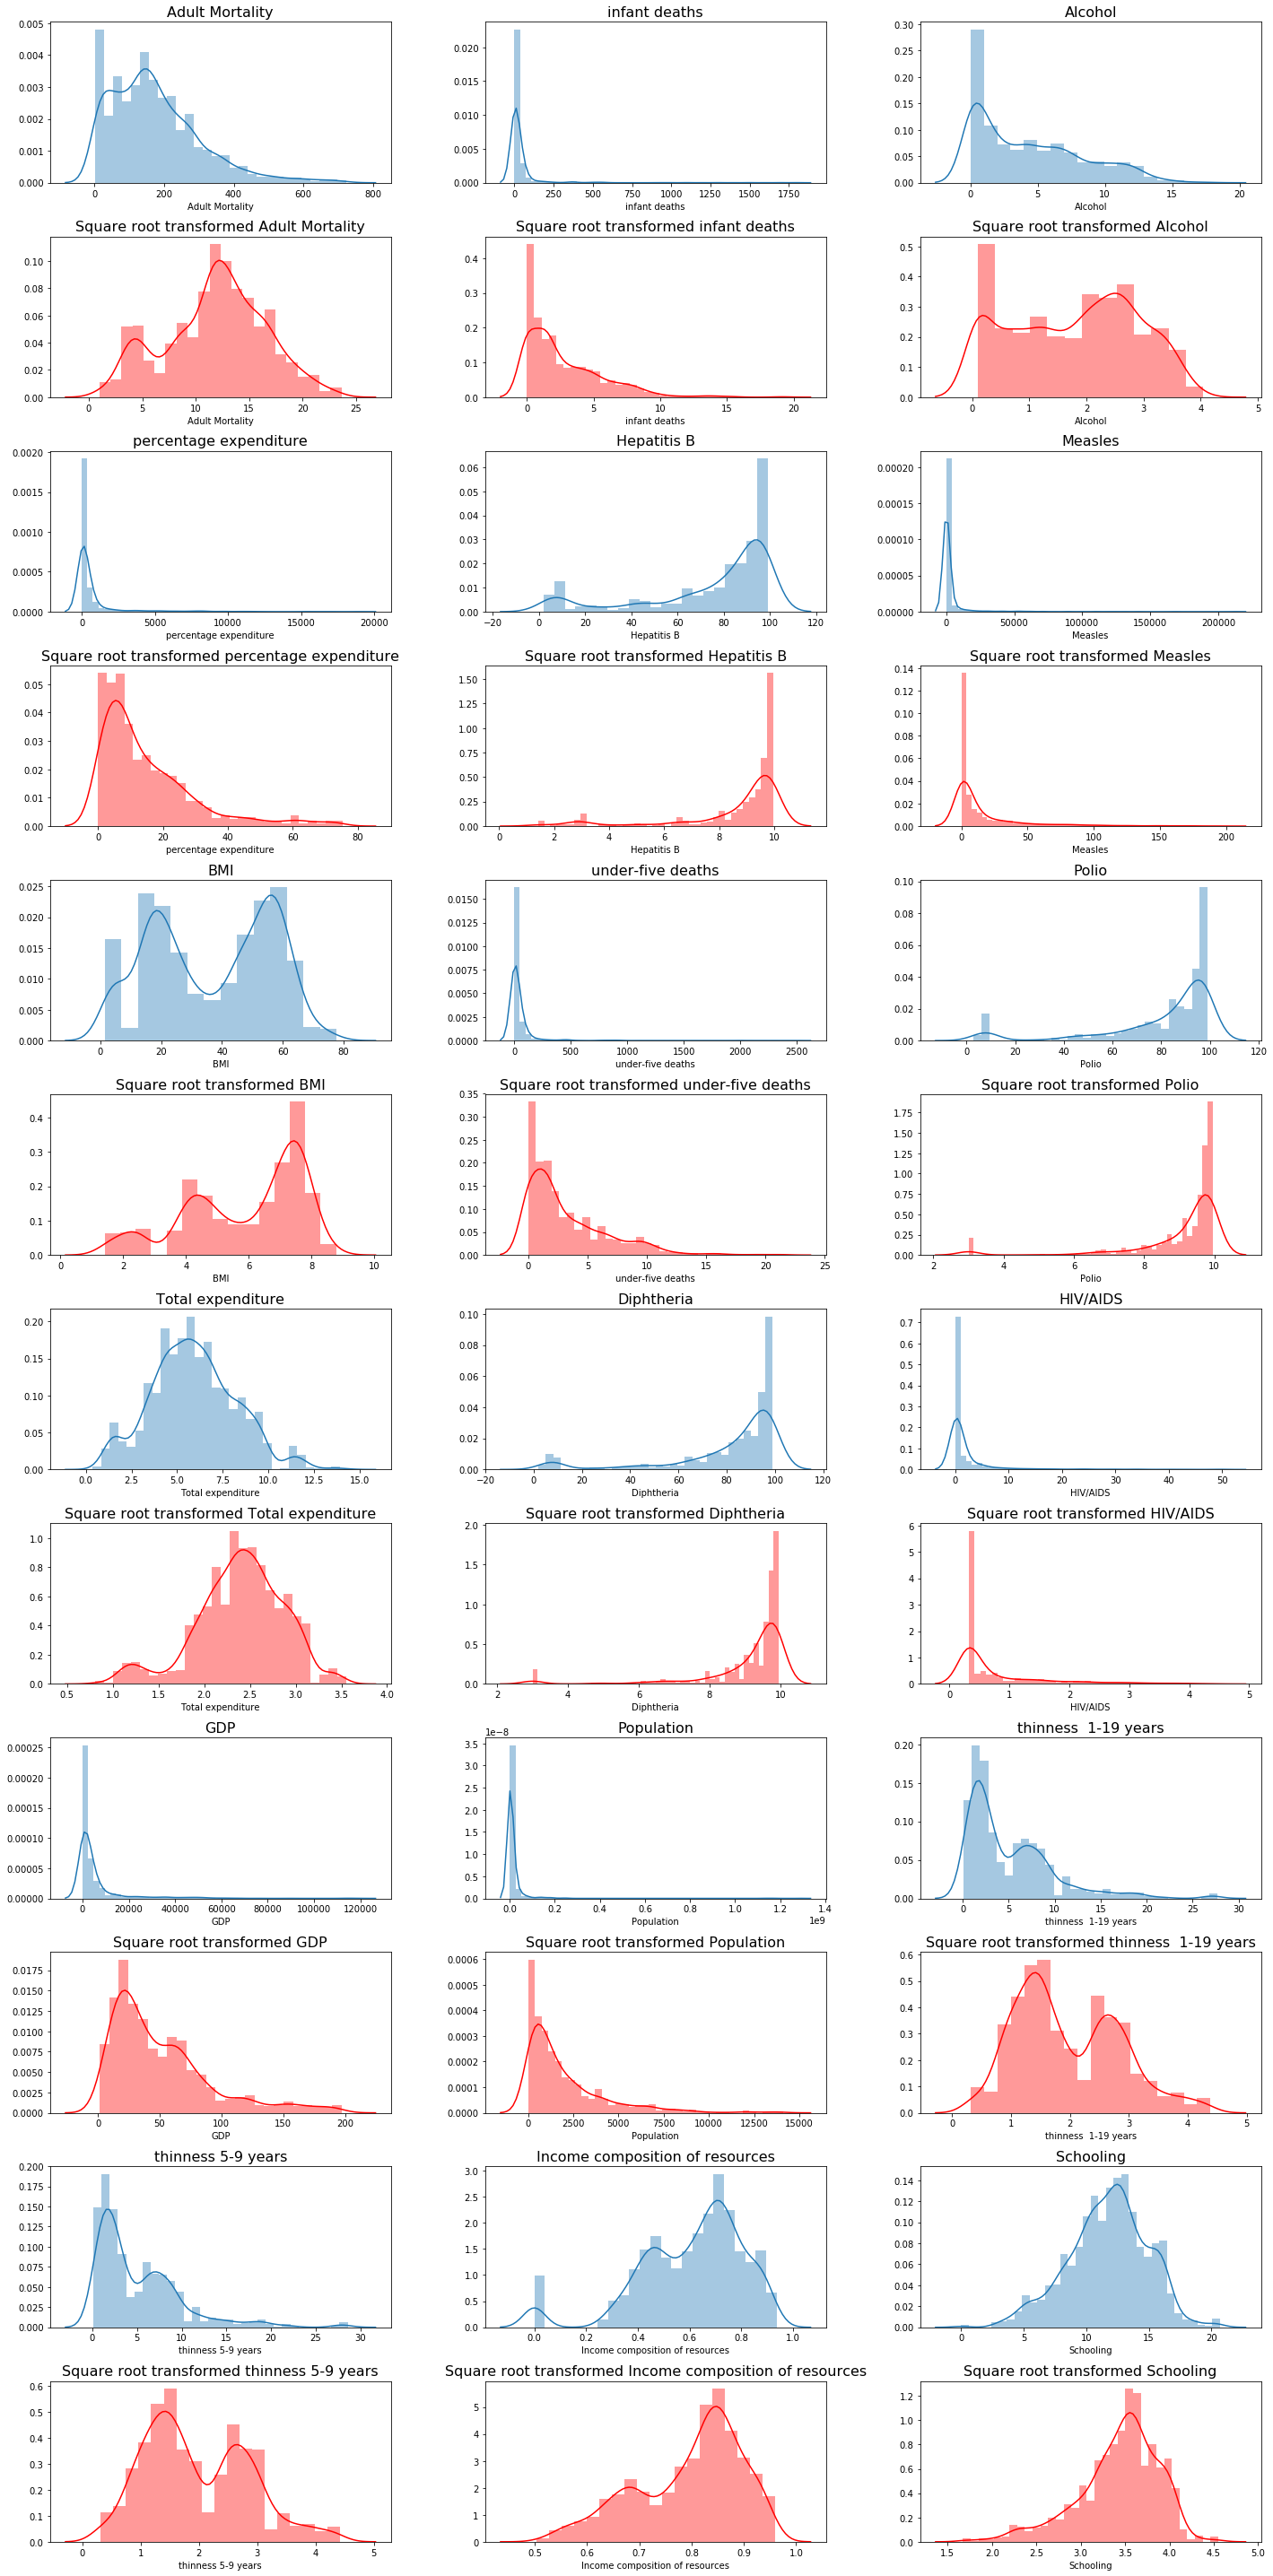

In [14]:
# apply two-way winsorization
adj_life_df = life_df.copy()
num_cols = adj_life_df.columns[4:] # all columns of interest (have to be numerical)


adj_life_df = adj_life_df[(np.abs(zscore(adj_life_df.iloc[:,4:])) < 3).all(axis=1)]
adj_life_df.iloc[:, 4:] = np.sqrt(adj_life_df.iloc[:, 4:])

# boxplot vaisualization of data before and after winsorization
plt.figure(figsize=(20, 40))

for i in range(1, len(num_cols)+1):
    
    # original data boxplots
    ind = 3*((i-1)//3)+i # for 1st row, 3rd row...
    plt.subplot(12, 3, ind)
    sns.distplot(life_df[num_cols[i-1]])
    plt.title('{}'.format(num_cols[i-1]), fontsize=16)
    
    # outliers beyond 4-z dropped
    ind2 = 3*((i-1)//3+1)+i # for 2nd row, 4th row...
    plt.subplot(12, 3, ind2)
    sns.distplot(adj_life_df[num_cols[i-1]], color='r')
    plt.title('Square root transformed {}'.format(num_cols[i-1]), fontsize=16)

plt.tight_layout()
plt.show()

In [15]:
# normality test some data

cols = ['Adult Mortality', 'Alcohol', 'Population', 'thinness  1-19 years', 'thinness 5-9 years']

# Test distribution normality for these columns
for col in cols:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(col))
    print("------------------------------------------------")

    jb_stats = jarque_bera(adj_life_df[col])
    norm_stats = normaltest(adj_life_df[col])
    print("Jarque-Bera test statistics on original data is {0:.3} and p value is {1:.3}".format(*jb_stats))
    print("Normality test statistics on original data is {0:.3} and p value is {1:.3}".format(*norm_stats))
    
    boxcox_jb_stats = jarque_bera(np.sqrt(adj_life_df[col]))
    boxcox_norm_stats  = normaltest(np.sqrt(adj_life_df[col]))
    print("Jarque-Bera test statistics on log transformed data is {0:.3} and p value is {1:.3}".format(*boxcox_jb_stats))
    print("Normality test statistics on log transformed data is {0:.3} and p value is {1:.3}".format(*boxcox_norm_stats))

------------------------------------------------
Comparisons for variable: Adult Mortality
------------------------------------------------
Jarque-Bera test statistics on original data is 23.3 and p value is 8.72e-06
Normality test statistics on original data is 33.7 and p value is 4.77e-08
Jarque-Bera test statistics on log transformed data is 1.44e+02 and p value is 0.0
Normality test statistics on log transformed data is 1.19e+02 and p value is 1.38e-26
------------------------------------------------
Comparisons for variable: Alcohol
------------------------------------------------
Jarque-Bera test statistics on original data is 99.6 and p value is 0.0
Normality test statistics on original data is 1.07e+03 and p value is 1.36e-233
Jarque-Bera test statistics on log transformed data is 1.58e+02 and p value is 0.0
Normality test statistics on log transformed data is 2.14e+02 and p value is 3.42e-47
------------------------------------------------
Comparisons for variable: Population


Distribution is not normal for most data but it's the closest it got after trying log and quantile trnasformations

In [16]:
# check correlation matrix after transformation
corr = adj_life_df.corr()
corr.style.background_gradient(cmap='RdBu_r')


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1,0.0817953,0.0173449,-0.0286606,-0.224155,-0.0489395,0.236644,-0.159074,0.0233112,-0.0309397,0.06874,0.0511983,0.1012,-0.0521762,0.101428,0.0123268,0.0359896,0.036904,0.0913057,0.150324
Life expectancy,0.0817953,1,-0.537018,-0.533305,0.402751,0.486886,0.200872,-0.258685,0.52488,-0.574163,0.366599,0.213887,0.372904,-0.743041,0.528447,0.00812742,-0.552815,-0.5494,0.887543,0.782648
Adult Mortality,0.0173449,-0.537018,1,0.296584,-0.185429,-0.281082,-0.068189,0.0983353,-0.29973,0.313419,-0.153261,-0.148377,-0.158984,0.438085,-0.284523,0.0225665,0.33731,0.344526,-0.452046,-0.393178
infant deaths,-0.0286606,-0.533305,0.296584,1,-0.331823,-0.335222,-0.108445,0.489444,-0.390668,0.99378,-0.222822,-0.159755,-0.21382,0.357171,-0.36125,0.419961,0.391779,0.411064,-0.566926,-0.519933
Alcohol,-0.224155,0.402751,-0.185429,-0.331823,1,0.446078,0.0651742,-0.140703,0.316582,-0.334258,0.174773,0.194381,0.184867,-0.126507,0.441187,0.0314305,-0.450392,-0.437843,0.543263,0.520908
percentage expenditure,-0.0489395,0.486886,-0.281082,-0.335222,0.446078,1,0.00809553,-0.121521,0.280742,-0.340364,0.151329,0.218467,0.14638,-0.241971,0.864838,0.0257515,-0.399543,-0.407064,0.526884,0.491687
Hepatitis B,0.236644,0.200872,-0.068189,-0.108445,0.0651742,0.00809553,1,-0.156807,0.150066,-0.116093,0.366624,0.131129,0.473588,-0.188192,0.0455827,0.00972709,-0.082513,-0.0865955,0.189374,0.213845
Measles,-0.159074,-0.258685,0.0983353,0.489444,-0.140703,-0.121521,-0.156807,1,-0.201576,0.490071,-0.136523,-0.12402,-0.139909,0.152691,-0.136613,0.21609,0.218094,0.237565,-0.254294,-0.267598
BMI,0.0233112,0.52488,-0.29973,-0.390668,0.316582,0.280742,0.150066,-0.201576,1,-0.412993,0.182945,0.189487,0.176934,-0.39815,0.331552,7.76893e-06,-0.526747,-0.539651,0.561398,0.497038
under-five deaths,-0.0309397,-0.574163,0.313419,0.99378,-0.334258,-0.340364,-0.116093,0.490071,-0.412993,1,-0.242707,-0.159219,-0.236963,0.396754,-0.371102,0.396909,0.408389,0.424156,-0.607356,-0.556962


***
# Dimensionality reduction & Linear regression

In [17]:
adj_life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1,Afghanistan,2014,Developing,59.9,16.462078,8.000000,0.1,8.574589,7.874008,22.181073,...,7.615773,2.860070,7.874008,0.316228,24.752707,572.347796,4.183300,4.183300,0.689928,3.162278
2,Afghanistan,2013,Developing,59.9,16.370706,8.124038,0.1,8.556824,8.000000,20.736441,...,7.874008,2.851315,8.000000,0.316228,25.134538,5633.088673,4.207137,4.207137,0.685565,3.146427
3,Afghanistan,2012,Developing,59.5,16.492423,8.306624,0.1,8.842184,8.185353,52.792045,...,8.185353,2.918904,8.185353,0.316228,25.883566,1922.747513,4.230839,4.242641,0.680441,3.130495
4,Afghanistan,2011,Developing,59.2,16.583124,8.426150,0.1,2.664040,8.246211,54.890801,...,8.246211,2.805352,8.246211,0.316228,7.971024,1725.861814,4.266146,4.266146,0.673795,3.082207
5,Afghanistan,2010,Developing,58.8,16.703293,8.602325,0.1,8.926330,8.124038,44.598206,...,8.124038,3.033150,8.124038,0.316228,23.522945,1697.989105,4.289522,4.289522,0.669328,3.033150


## PCA & Logestic Regression

82.1955312578472
0.9716312056737588


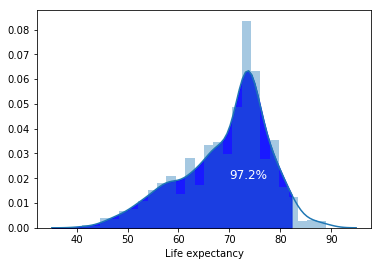

In [223]:
longivity_cutoff = adj_life_df['Life expectancy'].mean() + 1.5*adj_life_df['Life expectancy'].std()
p_cutoff = (adj_life_df['Life expectancy'] < longivity_cutoff).sum()/len(adj_life_df['Life expectancy'])
print(longivity_cutoff)
print(p_cutoff)
ax = sns.distplot(adj_life_df['Life expectancy'])
# fill area under distribution curve
line = ax.lines[0]
x1 = line.get_xydata()[:,0]
y1 = line.get_xydata()[:,1]
ax.fill_between(x1[x1<longivity_cutoff],y1[x1<longivity_cutoff], color="blue", alpha=0.9)
ax.text(s='{:.3}%'.format(p_cutoff*100), x=70, y=0.02, fontdict={'size':12, 'color':'white'})
plt.show()

Principal component 1 explains 35% and component 2 expalins 10%


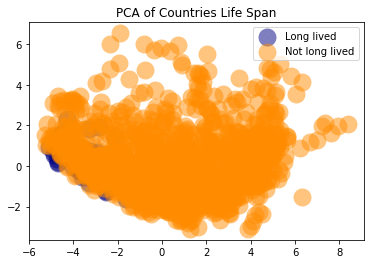

In [225]:
# make target column categorial
pca_life_df = adj_life_df.copy()
pca_life_df['Longevity'] = np.where(pca_life_df['Life expectancy'] > longivity_cutoff, 'Long lived', 'Not long lived')
pca_life_df.drop('Life expectancy', axis=1, inplace=True)

# split dataset into test and train
data = pca_life_df.loc[:, ~pca_life_df.columns.isin(['Longevity', 'Country', 'Status'])]
target = pca_life_df.loc[:, pca_life_df.columns == 'Longevity']
target.reset_index(inplace=True, drop=True)

# feature scaling
data = StandardScaler().fit_transform(data)

# initialize and fit PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# explained variance
explained_var = pca.explained_variance_ratio_
print('Principal component 1 explains {:.0f}% and component 2 expalins {:.0f}%'.format(*explained_var*100))

# visualize 2D-PCA
plt.figure()
colors = ['navy', 'darkorange']
target_names = ['Long lived', 'Not long lived']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(pca_data[np.where(target == target_name)[0], 0], pca_data[np.where(target == target_name)[0], 1], color=color, 
                alpha=.5, lw=12, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Countries Life Span')
plt.show()


In [ ]:
# features contribution to principal components


## LDA & logestic regression

In [270]:
# make target column categorial
lda_life_df = adj_life_df.copy()
lda_life_df['Longevity'] = np.where(lda_life_df['Life expectancy'] > longivity_cutoff, 'Long lived', 'Not long lived')
lda_life_df.drop('Life expectancy', axis=1, inplace=True)

# split dataset into test and train
data = lda_life_df.loc[:, ~lda_life_df.columns.isin(['Longevity', 'Country', 'Status'])]
target = lda_life_df.loc[:, lda_life_df.columns == 'Longevity']
target.reset_index(inplace=True, drop=True)

# initialize and fit LDA 
lda = LinearDiscriminantAnalysis(n_components = 2)
lda_data = lda.fit_transform(data, target)

# visualizing 1D-LDA
target['LDA-1'] = lda_data
sns.stripplot(y='LDA-1', x='Longivity', data=target)


/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(19, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/ipykernel_launc

ValueError: Could not interpret input 'Longivity'

In [274]:
target.columns[0] = 'Longivity'

TypeError: Index does not support mutable operations

In [230]:
# visualizing dimensionality reduction
figure()
colors = ['navy', 'darkorange']
target_name = ['Long lived', 'Not long lived']
lw = 2
 
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

legend(loc='best', shadow=False, scatterpoints=1)
title('PCA of IRIS dataset')

figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
legend(loc='best', shadow=False, scatterpoints=1)
title('LDA of IRIS dataset')

show()

NameError: name 'figure' is not defined

In the case when the number of different class labels, C, is less than the number of observations (almost always), then linear discriminant analysis will always produce C - 1 discriminating components. Because the number of different classes is 2, the dimensionality of the linear discriminant model can be at most 1-dimensional.

In [ ]:
# plt.figure(figsize = (10,7))
# sns.set_context( rc={'lines.markersize': 10, 'xtick.labelsize': 16, 'ytick.labelsize': 16}) # override marker and ticklabel size
# g = sns.lineplot(y=pca_res.explained_variance_ratio_, x=list(range(1,len(pca_res.explained_variance_ratio_)+1)), marker="o", label='Idvidual')
# sns.lineplot(y=pca_res.explained_variance_ratio_.cumsum(), x=list(range(1,len(pca_res.explained_variance_ratio_)+1)), marker="o", label='Cumulative')
# sns.set_style('darkgrid')
# plt.setp(g.lines,linewidth=3) # for line width
# g.lines[1].set_linestyle("--") # for line style
# plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
# plt.xlabel('Principal component', fontsize='16') # x-axis label
# plt.ylabel('Explained variance ratio', fontsize='16') # y-axis label
# g.set(xticks=list(range(1,6)))
# plt.show()

# print('PCA 1st component explains {:.3}% of the expenditure variance'.format(pca_res.explained_variance_ratio_[0]*100))

# # check correlation with 1st principal component with rest of features
# adj_life_df['PCA_1'] = PCA(n_components=1).fit_transform(z_data)
# corr = adj_life_df.corr()
# corr.style.background_gradient(cmap='RdBu_r')